In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["linear_reg", "ffnn" "ffnn_wmse"]

## 1) Aggregate all results

In [4]:
all_data = []
model_summary = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            data = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            mse = mean_squared_error(y_true=data["y"],
                                     y_pred=data["pred"])
            mae = mean_absolute_error(y_true=data["y"],
                                      y_pred=data["pred"])

            model_summary_tmp = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            model_summary_tmp["model"] = model_tag
            model_summary_tmp["dgp"] = dgp_name
            model_summary_tmp["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            model_summary_tmp["dataset"] = ds
            model_summary_tmp["mse"] = mse
            model_summary_tmp["mae"] = mae
            if model_tag == "linear_reg":
                model_summary_tmp['coef'] = str(tuple(map(tuple, model_summary_tmp['coef']))[0])
            
            model_summary.append(pd.DataFrame(model_summary_tmp, index=[idx]))
            idx += 1
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)
model_summary_df = pd.concat(model_summary, axis=0)

Append all model results: 100%|██████████| 2/2 [00:15<00:00,  7.79s/it]


## 2) Compute relevant metrics

> a) Mean squared error

> b) Mean absolute error

In [8]:
metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mae_melt).reset_index()

### MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

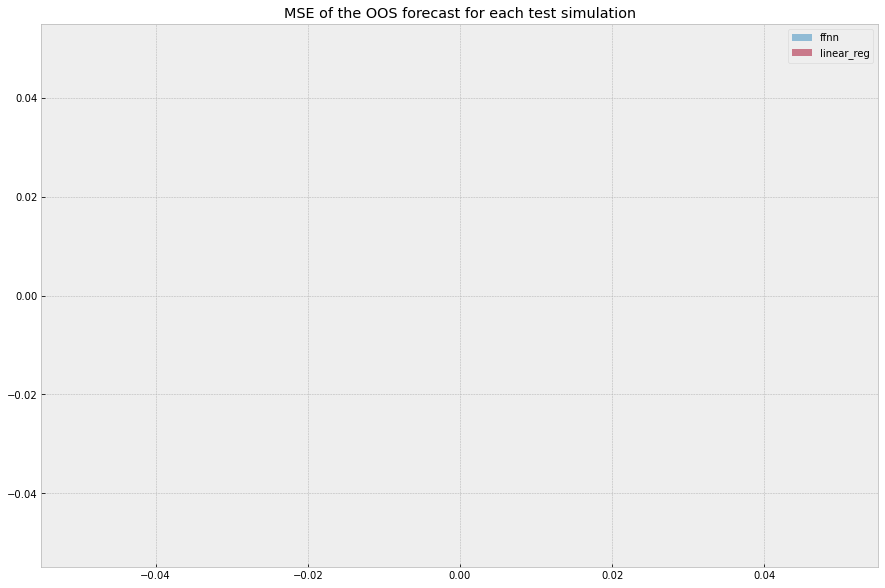

In [9]:
ffnn_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn"][["mse"]]
ffnn_hist_mse.rename(columns={"mse": "ffnn mse"}, inplace=True)

ffnn_wmse_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn_wmse"][["mse"]]
ffnn_wmse_hist_mse.rename(columns={"mse": "ffnn_wmse mse"}, inplace=True)

linear_reg_hist_mse = mse_group_df.loc[mse_group_df["model"]=="linear_reg"][["mse"]]
linear_reg_hist_mse.rename(columns={"mse": "linear_reg mse"}, inplace=True)

hist_mse_df = pd.concat([ffnn_hist_mse.reset_index(drop=True), linear_reg_hist_mse.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
plt.hist(hist_mse_df[hist_mse_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mse_df[hist_mse_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

### MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

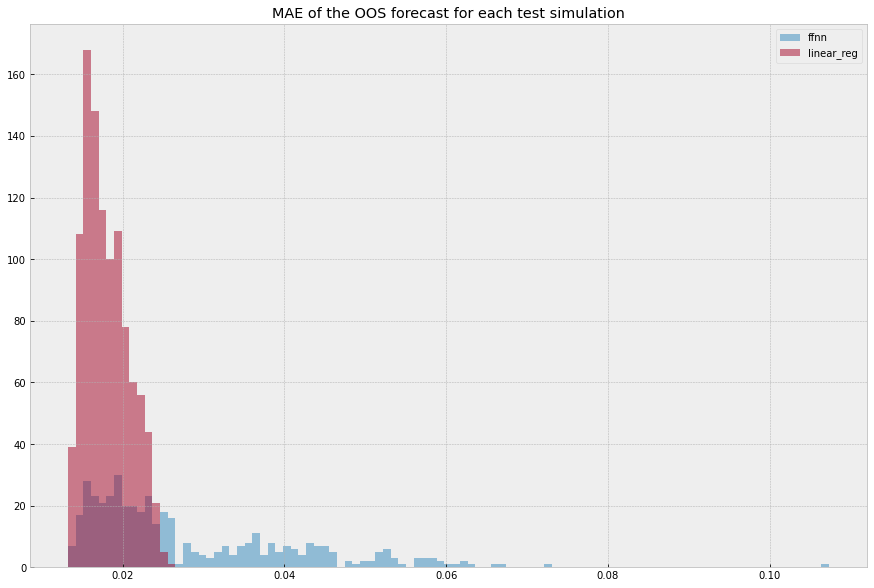

In [5]:
ffnn_hist_mae = mae_group_df.loc[mae_group_df["model"]=="ffnn"][["mae"]]
ffnn_hist_mae.rename(columns={"mae": "ffnn mae"}, inplace=True)

linear_reg_hist_mae = mae_group_df.loc[mae_group_df["model"]=="linear_reg"][["mae"]]
linear_reg_hist_mae.rename(columns={"mae": "linear_reg mae"}, inplace=True)

hist_mae_df = pd.concat([ffnn_hist_mae.reset_index(drop=True), linear_reg_hist_mae.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
plt.hist(hist_mae_df[hist_mae_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mae_df[hist_mae_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

## 3) Analysis of the chosen FFNN architectures

### Distribution of the number of hidden units and neurons per unit

In [6]:
ffnn_summary_df = model_summary_df.loc[model_summary_df['model'] == "ffnn"]
linear_reg_summary_df = model_summary_df.loc[model_summary_df['model'] == "linear_reg"]

Text(0.5, 1.0, 'Distribution of the number of hidden units in each chosen ffnn')

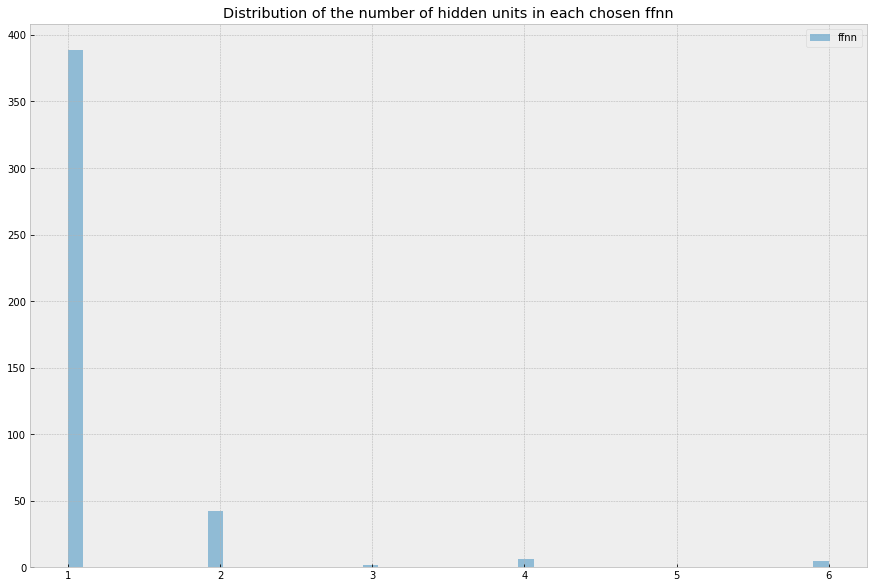

In [7]:
bins = np.linspace(ffnn_summary_df['n_hidden'].min(), ffnn_summary_df['n_hidden'].max(), 50)
plt.hist(ffnn_summary_df['n_hidden'], bins, alpha=0.5, label='ffnn')
plt.legend(loc='upper right')
plt.title("Distribution of the number of hidden units in each chosen ffnn")

Text(0.5, 1.0, 'Distribution of the number of neurons per hidden units in each chosen ffnn')

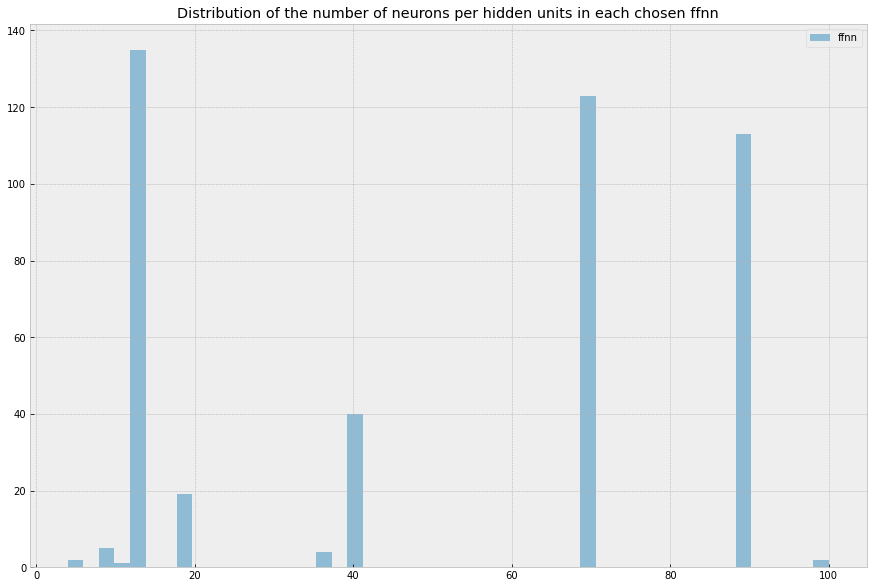

In [8]:
bins = np.linspace(ffnn_summary_df['n_neurons'].min(), ffnn_summary_df['n_neurons'].max(), 50)
plt.hist(ffnn_summary_df['n_neurons'], bins, alpha=0.5, label='ffnn')
plt.legend(loc='upper right')
plt.title("Distribution of the number of neurons per hidden units in each chosen ffnn")

### Analysis of the parameters of the best ffnn architectures

In [9]:
ffnn_summary_df.sort_values("mse", ascending=True).head(20).dropna(axis=1)

,model,dgp,number_of_variables,dataset,mse,mae,activation,input_shape,learning_rate,loss,n_hidden,n_neurons
1299,ffnn,ar1_493_random,493,betadgp_covdgp_data,0.001512,0.013777,relu,1.0,0.022396,mse,1.0,70.0
1260,ffnn,ar1_472_random,472,betadgp_covdgp_data,0.001562,0.014536,relu,1.0,0.022396,mse,1.0,70.0
1236,ffnn,ar1_469_random,469,betadgp_covdgp_data,0.001563,0.014000,relu,1.0,0.022842,mse,1.0,90.0
1401,ffnn,ar1_487_random,487,betadgp_covdgp_data,0.001566,0.014407,relu,1.0,0.022396,mse,1.0,70.0
1284,ffnn,ar1_448_random,448,betadgp_covdgp_data,0.001598,0.014542,relu,1.0,0.022842,mse,1.0,90.0
1215,ffnn,ar1_488_random,488,betadgp_covdgp_data,0.001601,0.016457,relu,1.0,0.022396,mse,1.0,70.0
1434,ffnn,ar1_466_random,466,betadgp_covdgp_data,0.001603,0.015123,relu,1.0,0.022396,mse,1.0,70.0
1254,ffnn,ar1_430_random,430,betadgp_covdgp_data,0.001605,0.014785,relu,1.0,0.022396,mse,1.0,70.0
1272,ffnn,ar1_460_random,460,betadgp_covdgp_data,0.001605,0.014343,relu,1.0,0.022396,mse,1.0,70.0
1323,ffnn,ar1_491_random,491,betadgp_covdgp_data,0.001607,0.013809,relu,1.0,0.022396,mse,1.0,70.0


In [10]:
ffnn_summary_df.sort_values("mse", ascending=True).tail(20).dropna(axis=1)

,model,dgp,number_of_variables,dataset,mse,mae,activation,input_shape,learning_rate,loss,n_hidden,n_neurons
1055,ffnn,ar1_150_random,150,betadgp_data,0.006843,0.052733,relu,2.0,0.000574,mse,1.0,13.0
1349,ffnn,ar1_184_random,184,betadgp_data,0.006902,0.053325,relu,2.0,0.000564,mse,1.0,19.0
1376,ffnn,ar1_366_random,366,betadgp_data,0.007070,0.058123,relu,2.0,0.000574,mse,1.0,13.0
1496,ffnn,ar1_171_random,171,betadgp_data,0.007194,0.057746,relu,2.0,0.000574,mse,1.0,13.0
1154,ffnn,ar1_164_random,164,betadgp_data,0.007306,0.052975,relu,2.0,0.000564,mse,1.0,19.0
1430,ffnn,ar1_329_random,329,betadgp_data,0.007359,0.061251,relu,2.0,0.000574,mse,1.0,13.0
1397,ffnn,ar1_173_random,173,betadgp_data,0.007421,0.058183,relu,2.0,0.000574,mse,1.0,13.0
1412,ffnn,ar1_201_random,201,betadgp_data,0.007548,0.059110,relu,2.0,0.000574,mse,1.0,13.0
1322,ffnn,ar1_165_random,165,betadgp_data,0.007638,0.056679,relu,2.0,0.000574,mse,1.0,13.0
1061,ffnn,ar1_174_random,174,betadgp_data,0.007694,0.057987,relu,2.0,0.000574,mse,1.0,13.0


In [12]:
model_summary_df.head()

,coef,model,dgp,number_of_variables,dataset,mse,mae,activation,input_shape,learning_rate,loss,n_hidden,n_neurons
0,"(0.0009639355172091853,)",linear_reg,ar1_150_random,150,betadgp_covdgp_data,0.004292,0.023054,NaN,NaN,NaN,NaN,NaN,NaN
1,"(-4.871893774449197e-05,)",linear_reg,ar1_150_random,150,betadgp_beta2x2_data,0.004845,0.024207,NaN,NaN,NaN,NaN,NaN,NaN
2,"(-0.0026842849049166606, -0.001154914322603748)",linear_reg,ar1_150_random,150,betadgp_data,0.004888,0.023796,NaN,NaN,NaN,NaN,NaN,NaN
3,"(0.00021524442841717694,)",linear_reg,ar1_384_random,384,betadgp_covdgp_data,0.001932,0.015416,NaN,NaN,NaN,NaN,NaN,NaN
4,"(0.0001350462649294919,)",linear_reg,ar1_384_random,384,betadgp_beta2x2_data,0.002677,0.016306,NaN,NaN,NaN,NaN,NaN,NaN


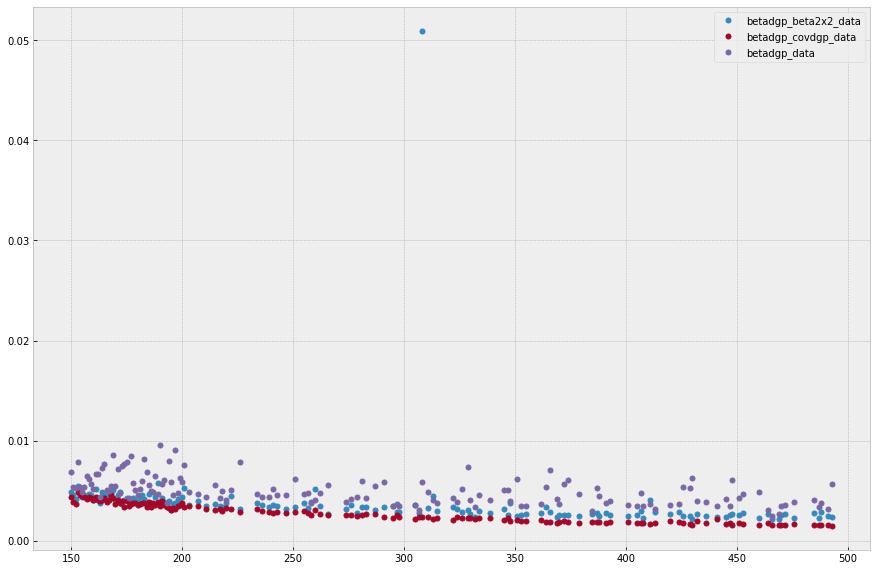

In [13]:
ffnn_achitectures_df = model_summary_df.loc[model_summary_df["model"] == "ffnn"]
groups = ffnn_achitectures_df.groupby("dataset")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["number_of_variables"],
            group["mse"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.legend()

### Analysis of the parameters of the best linear_reg

In [14]:
linear_reg_summary_df.sort_values("mse", ascending=True).head(20).dropna(axis=1)

,coef,model,dgp,number_of_variables,dataset,mse,mae
813,"(0.0005767225015363976,)",linear_reg,ar1_495_random,495,betadgp_covdgp_data,0.001352,0.013217
825,"(0.001315320155226175,)",linear_reg,ar1_499_random,499,betadgp_covdgp_data,0.001417,0.013262
174,"(0.001155887781277533,)",linear_reg,ar1_455_random,455,betadgp_covdgp_data,0.001442,0.013639
207,"(0.0014147554565225554,)",linear_reg,ar1_500_random,500,betadgp_covdgp_data,0.001446,0.013456
666,"(0.0011444539093500425,)",linear_reg,ar1_483_random,483,betadgp_covdgp_data,0.001461,0.013565
369,"(0.0005596964472279746,)",linear_reg,ar1_494_random,494,betadgp_covdgp_data,0.001462,0.013590
21,"(0.0009960862168031416,)",linear_reg,ar1_492_random,492,betadgp_covdgp_data,0.001466,0.013602
375,"(0.0009239691082873969,)",linear_reg,ar1_498_random,498,betadgp_covdgp_data,0.001471,0.013704
639,"(0.0014672787155626166,)",linear_reg,ar1_481_random,481,betadgp_covdgp_data,0.001499,0.013593
531,"(0.0010878798159725997,)",linear_reg,ar1_472_random,472,betadgp_covdgp_data,0.001500,0.013750


In [15]:
linear_reg_summary_df.sort_values("mse", ascending=True).tail(20).dropna(axis=1)

,coef,model,dgp,number_of_variables,dataset,mse,mae
378,"(-0.0005688408518559703,)",linear_reg,ar1_160_random,160,betadgp_covdgp_data,0.004482,0.023487
400,"(0.0005157670959887142,)",linear_reg,ar1_162_random,162,betadgp_beta2x2_data,0.004485,0.022837
304,"(0.001778062322711968,)",linear_reg,ar1_181_random,181,betadgp_beta2x2_data,0.004528,0.023431
305,"(-0.0014885940513324285, -0.00048657564065080475)",linear_reg,ar1_181_random,181,betadgp_data,0.004540,0.023349
821,"(0.005980350029110151, 0.0038022319682759578)",linear_reg,ar1_161_random,161,betadgp_data,0.004548,0.025551
820,"(0.0005640102469751403,)",linear_reg,ar1_161_random,161,betadgp_beta2x2_data,0.004556,0.023643
28,"(0.0011095360580087774,)",linear_reg,ar1_166_random,166,betadgp_beta2x2_data,0.004599,0.022765
29,"(0.0040505542875685155, 0.0019100863743440187)",linear_reg,ar1_166_random,166,betadgp_data,0.004600,0.024092
391,"(0.0044981849142318765,)",linear_reg,ar1_156_random,156,betadgp_beta2x2_data,0.004683,0.025627
392,"(0.0060021211933253904, 0.003190731715787179)",linear_reg,ar1_156_random,156,betadgp_data,0.004706,0.025496


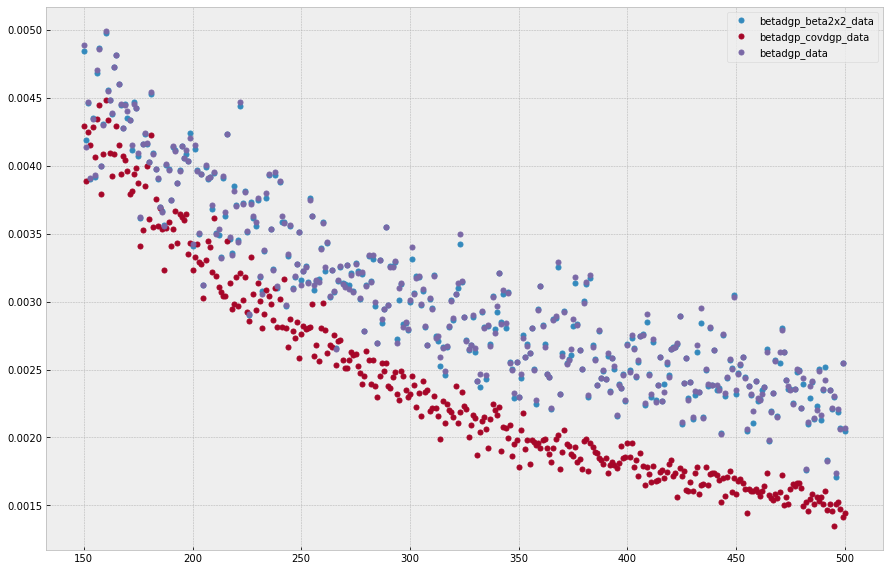

In [16]:
groups = linear_reg_summary_df.groupby("dataset")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["number_of_variables"],
            group["mse"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.legend()

### Scatter plot for the true beta (y) as a function of the predicted values (x) for the best models

In [21]:
best_ffnn_df = all_data_df.loc[(all_data_df["dgp"] == "ar1_150_random")&
                               (all_data_df["dataset"] == "betadgp_data")&
                               (all_data_df["model"] == "ffnn")]
best_linear_reg_df = all_data_df.loc[(all_data_df["dgp"] == "ar1_150_random")&
                                     (all_data_df["dataset"] == "betadgp_data")&
                                     (all_data_df["model"] == "linear_reg")]

Text(0.5, 1.0, 'Distribution of the true VAR betas')

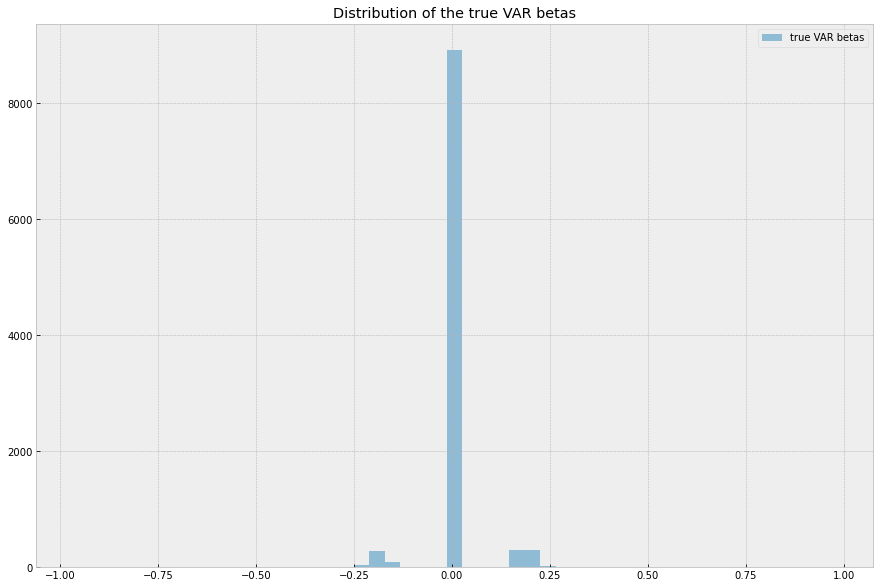

In [28]:
bins = np.linspace(best_linear_reg_df['y'].min(), best_linear_reg_df['y'].max(), 50)
plt.hist(best_linear_reg_df['y'], bins, alpha=0.5, label='true VAR betas')
plt.legend(loc='upper right')
plt.title("Distribution of the true VAR betas")

#### FFNN

<AxesSubplot:xlabel='pred', ylabel='y'>

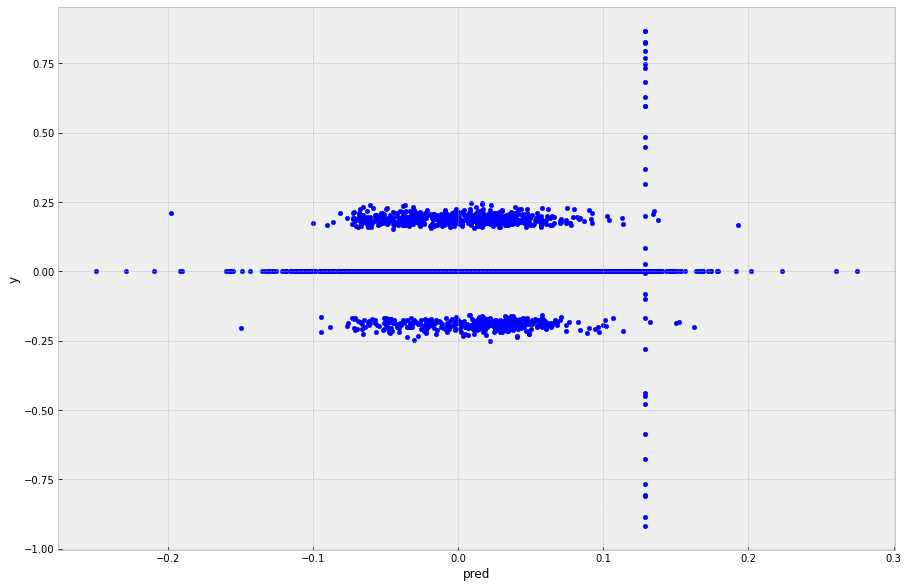

In [22]:
best_ffnn_df.plot.scatter(y="y", x="pred")

#### Linear regression

<AxesSubplot:xlabel='pred', ylabel='y'>

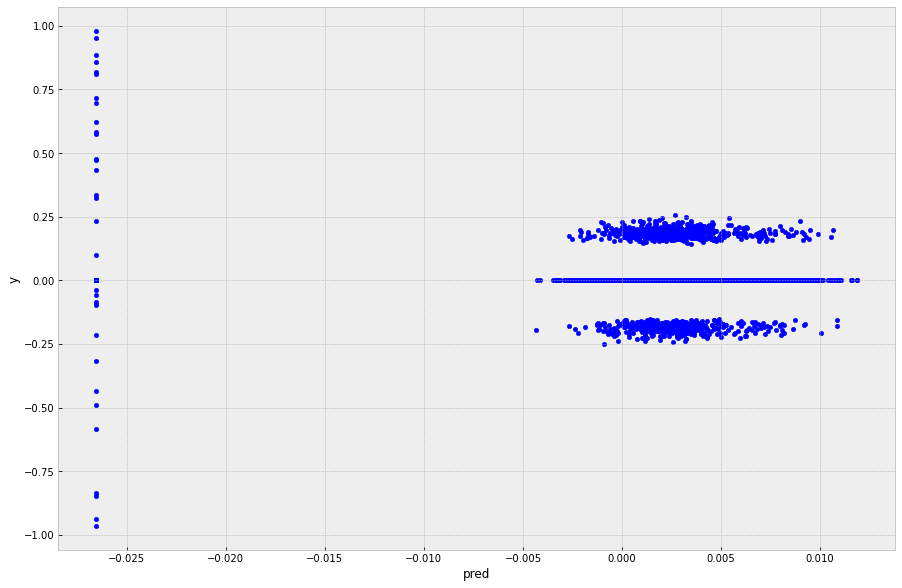

In [23]:
best_linear_reg_df.plot.scatter(y="y", x="pred")